# Trip Duration Prediction

This notebook is part of [*Practical Data Science for IOT*](https://github.com/pablodecm/datalab_ml_iot) tutorial by Pablo de Castro

## Tools

This notebook will use the following Python 3
libraries for data analytics and machine learning:
- pandas
- numpy
- matplotlib/seaborn
- scikit-learn
- xgboost
- leaflet/folium

In [5]:
!pip install seaborn
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

## Dataset

In this notebook, we are gonna be using a large dataset from
the [Kaggle New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)
challenge, which corresponds to real taxi trips data in the city
of New York within the year 2016.

The main task is the prediction of the trip duration given the features, but it
is a really good dataset for exploratory data analysis and applying some
tricks for dealing with location and temporal data in cities.

<div align="center">
  <img src="https://github.com/pablodecm/datalab_ml_iot/blob/master/02_trip_duration_prediction/images/kaggle_trip_duration.png?raw=1" height="50%" style="max-width: 50%">
</div>

### Data fields

Here is a list and description of all the provided items for each trip:
- **id** - a unique identifier for each trip
- **vendor_id** - a code indicating the provider associated with the trip record
- **pickup_datetime** - date and time when the meter was engaged
- **dropoff_datetime** - date and time when the meter was disengaged
- **passenger_count** - the number of passengers in the vehicle (driver entered value)
- **pickup_longitude** - the longitude where the meter was engaged
- **pickup_latitude** - the latitude where the meter was engaged
- **dropoff_longitude** - the longitude where the meter was disengaged
- **dropoff_latitude** - the latitude where the meter was disengaged
- **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server -  Y=store and forward; N=not a store and forward trip
- **trip_duration** - duration of the trip in seconds


### Download from Kaggle

In order to download datasets from Kaggle with can use the
official CLI interface, but it requires you to have an account
and to get an API key.

In [3]:
!pip install kaggle
!mkdir $HOME/.kaggle

In [4]:
# run if in Google Colab to setup your Kaggle API Key
import json
import getpass
import os

kaggle_json_path = "$HOME/.kaggle/kaggle.json"
if not os.path.isfile(os.path.expandvars(kaggle_json_path)):
  username = getpass.getpass('username')
  api_key = getpass.getpass('Kaggle API key')

  token = {"username": username,"key":api_key}
  with open('kaggle.json', 'w') as file:
      json.dump(token, file)
    
  # jupyter/ipython bash magic (!) works within an if
  !mv kaggle.json $HOME/.kaggle/kaggle.json
  !chmod 600 $HOME/.kaggle/kaggle.json

!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
unanimad/dataisbeautiful                                       Reddit - Data is Beautiful                           11MB  2020-03-21 22:28:28           1079  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)  646MB  2020-03-20 23:31:34          32695  
rubenssjr/brasilian-houses-to-rent                             brazilian_houses_to_rent                            282KB  2020-03-25 22:51:17           1016  
charlieharper/spatial-data-for-cord19-covid19-ordc             Spatial Data for CORD-19 (COVID-19 ORDC)            136MB  2020-03-24 20:17:09             76  
clmentbisaillon/fake-and-real-news-dataset    

In [5]:
!mkdir data
!cd data; kaggle competitions download -c nyc-taxi-trip-duration; cd ..
!cd data; unzip -o nyc-taxi-trip-duration.zip; unzip -o train.zip; unzip -o test.zip; cd ..

 44% 9.00M/20.3M [00:00<00:00, 29.3MB/s]
100% 20.3M/20.3M [00:00<00:00, 45.8MB/s]
  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 166MB/s]
 65% 41.0M/62.9M [00:00<00:00, 90.0MB/s]
100% 62.9M/62.9M [00:00<00:00, 117MB/s] 
unzip:  cannot find or open nyc-taxi-trip-duration.zip, nyc-taxi-trip-duration.zip.zip or nyc-taxi-trip-duration.zip.ZIP.
Archive:  train.zip
  inflating: train.csv               
Archive:  test.zip
  inflating: test.csv                


In [6]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print("train shape: ", train_df.shape, "test shape: ", test_df.shape)

train shape:  (1458644, 11) test shape:  (625134, 9)


In [7]:
train_df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [8]:
test_df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


#### Warming up Exercise

Check that id is unique and train and test set are distinct.

*Hint: Look up `DataFrame.nunique` and `np.intersect1d` in their respective documentations.*

In [0]:
# write here the exercise
train_df.nunique()

### Additional Datasets

In real-world scenarios, there is often something to gain
by combining data from different sources that might be informative
for the task.

In the case of car trip durations, traffic routes and weather
are quite relevant and were allowed in the competition.
Participants have
curated two datasets that might be of use here:
- Traffic route details using the [Open Source Routing Machine OSRM tool](http://project-osrm.org/)
- Weather during the period considered
Part of the information of the former will be used while
the use of the later if left for future extensions.

In [1]:
# traffic route from OSRM
!cd data; kaggle datasets download oscarleo/new-york-city-taxi-with-osrm; cd ..
!mkdir data/osrm
!unzip -o data/new-york-city-taxi-with-osrm.zip -d data/osrm

100% 515M/515M [00:03<00:00, 155MB/s]

Archive:  data/new-york-city-taxi-with-osrm.zip
  inflating: data/osrm/accidents_2016.csv  
  inflating: data/osrm/fastest_routes_test.csv  
  inflating: data/osrm/fastest_routes_train_part_1.csv  
  inflating: data/osrm/fastest_routes_train_part_2.csv  
  inflating: data/osrm/second_fastest_routes_test.csv  
  inflating: data/osrm/second_fastest_routes_train.csv  
  inflating: data/osrm/test.csv      
  inflating: data/osrm/train.csv     


In [2]:
# weather data
!cd data; kaggle datasets download mathijs/weather-data-in-new-york-city-2016; cd ..
!mkdir data/weather
!unzip -o data/weather-data-in-new-york-city-2016.zip -d data/weather


  0% 0.00/3.11k [00:00<?, ?B/s]
100% 3.11k/3.11k [00:00<00:00, 5.39MB/s]
Archive:  data/weather-data-in-new-york-city-2016.zip
  inflating: data/weather/weather_data_nyc_centralpark_2016(1).csv  


In [9]:
# add some columns to the train and test data
cols_osrm = ['id', 'total_distance', 'total_travel_time',  'number_of_steps']
fr1 = pd.read_csv('data/osrm/fastest_routes_train_part_1.csv', usecols=cols_osrm)
fr2 = pd.read_csv('data/osrm/fastest_routes_train_part_2.csv', usecols=cols_osrm)
test_street_info = pd.read_csv('data/osrm/fastest_routes_test.csv',
                               usecols=cols_osrm)
train_street_info = pd.concat((fr1, fr2))
train_df = train_df.merge(train_street_info, how='left', on='id')
test_df = test_df.merge(test_street_info, how='left', on='id')

train_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0


## Exploratory Data Analysis (EDA)

It is good to get used to the properties data in an interactive
manner before carrying out any model building, which is often done
by some basic visualization and summary descriptions.

In [0]:
train_df.describe()

In [0]:
# really long trips present
3.526282e+06/3600

We can remove outliers to simplify the analysis and make it
more robust, e.g. we can safely remove trips with a duration
further away from the mean than 3 standard deviations.

In [10]:
m = np.mean(train_df['trip_duration'])
s = np.std(train_df['trip_duration'])
# filter 
filter_duration = ((train_df['trip_duration'] <= m + 3*s) &
                   (train_df['trip_duration'] >= m - 3*s))
(~filter_duration).sum()

2073

Similarly, the bounding box limits of the city of New York can
be easily checked and used for limiting the exploration of data
to trips which were started or finished within the city.

In [11]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
filter_location = ((train_df['pickup_longitude'] <= city_long_border[1]) &
                   (train_df['pickup_longitude'] >= city_long_border[0]) &
                   (train_df['pickup_latitude'] <= city_lat_border[1]) &
                   (train_df['pickup_latitude'] >= city_lat_border[0]) &
                   (train_df['dropoff_longitude'] <= city_long_border[1]) &
                   (train_df['dropoff_longitude'] >= city_long_border[0]) &
                   (train_df['dropoff_latitude'] <= city_lat_border[1]) &
                   (train_df['dropoff_latitude'] >= city_lat_border[0]))
                                 
(~filter_location).sum()

19461

In [12]:
# in case you have not heard of it
# this is a very useful DataFrame function
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
total_distance        1458643 non-null float64
total_travel_time     1458643 non-null float64
number_of_steps       1458643 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 166.9+ MB


### Data Preparation

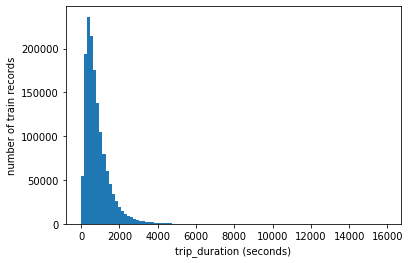

In [13]:
fig, ax = plt.subplots()

ax.hist(train_df.loc[filter_duration,'trip_duration'].values, bins=100)
ax.set_xlabel('trip_duration (seconds)')
ax.set_ylabel('number of train records');

Text(0, 0.5, 'number of train records')

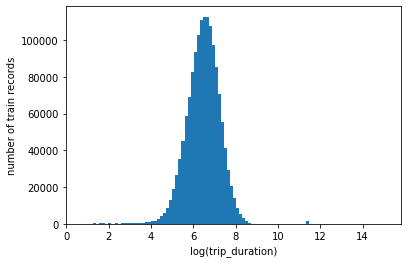

In [14]:
train_df['log_trip_duration'] = np.log(train_df['trip_duration'].values + 1)

fig, ax = plt.subplots()

ax.hist(train_df['log_trip_duration'].values, bins=100)
ax.set_xlabel('log(trip_duration)')
ax.set_ylabel('number of train records')

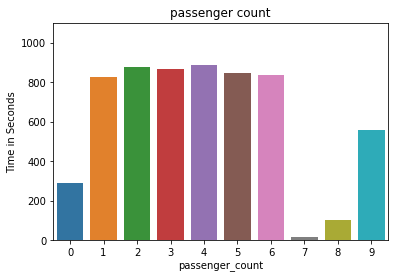

In [15]:
pc = train_df[filter_duration].groupby('passenger_count')['trip_duration'].mean()

fig, ax = plt.subplots()
ax.set_ylim(ymin=0)
ax.set_ylim(ymax=1100)
plt.title('passenger count')
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [0]:
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)
train_df.loc[:, 'pickup_date'] = train_df['pickup_datetime'].dt.date
test_df.loc[:, 'pickup_date'] = test_df['pickup_datetime'].dt.date
train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


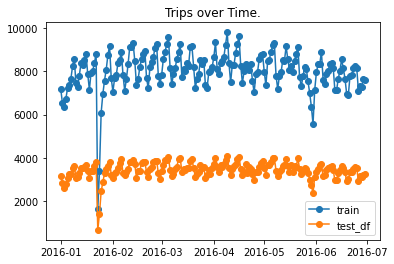

In [17]:

fig, ax = plt.subplots()
ax.plot(train_df.groupby('pickup_date').count()[['id']],
         'o-', label='train')
ax.plot(test_df.groupby('pickup_date').count()[['id']],
         'o-', label='test_df')
ax.set_title('Trips over Time.')
ax.legend(loc=0);

(-74.03, -73.75)

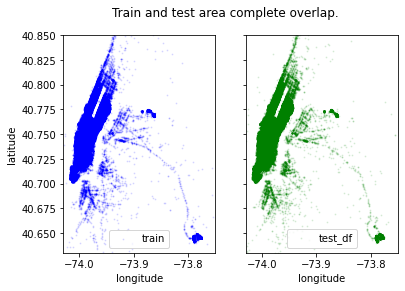

In [18]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train_df['pickup_longitude'].values[:100000], train_df['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test_df['pickup_longitude'].values[:100000], test_df['pickup_latitude'].values[:100000],
              color='green', s=1, label='test_df', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### Folium: Interactive Maps in the Jupyter Notebook


Folium is a flexible Python library that can be used to work with interactive Leaflet.js maps.

In [19]:
!pip install folium
import folium

In [31]:
location = (37.851051, -61.335529)
m = folium.Map(location=location,
               zoom_start=13)

popup = '<b>Us!</b>'
folium.Marker(location, popup=popup).add_to(m)

m

#### Folium Exercise

In addition of New York State, where else where New York
taxis picked up? Represent some of far the location outliers
(remember the `~filter_location` variable) in a Folium map.


In [32]:
mydf = train_df.loc[~filter_location]
mydf = mydf.loc[mydf['pickup_longitude'] > -70]
mydf

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps,log_trip_duration,pickup_date
782256,id0267429,1,2016-02-22 20:25:33,2016-02-22 20:41:34,2,-65.848389,34.359695,-65.848389,34.359695,N,961,0.0,0.0,2.0,6.869014,2016-02-22
804402,id1974018,1,2016-01-22 16:52:09,2016-01-22 16:58:18,2,-61.335529,37.851051,-61.335529,37.851051,N,369,0.0,0.0,2.0,5.913503,2016-01-22
962552,id3525158,1,2016-01-15 14:01:34,2016-01-15 14:07:59,1,-68.778435,36.118538,-68.778435,36.118538,N,385,0.0,0.0,2.0,5.955837,2016-01-15
1060807,id0838705,1,2016-02-26 19:50:03,2016-02-26 20:08:54,1,-66.972160,44.371944,-69.048019,43.147583,N,1131,0.0,0.0,2.0,7.031741,2016-02-26
1387351,id0205460,1,2016-01-10 16:46:16,2016-01-10 16:51:45,1,-65.897385,39.457882,-65.897385,39.457882,N,329,0.0,0.0,2.0,5.799093,2016-01-10


## More Advanced Feature Engineering

### Principal Component Analysis (PCA)

In some cases, PCA over some of the features can be used to
obtain transformed features that can be used more efficiently
for model training.


In [33]:
from sklearn.decomposition import PCA
# fit PCA
coords = np.vstack((train_df[['pickup_latitude',
                           'pickup_longitude']].values,
                    train_df[['dropoff_latitude',
                           'dropoff_longitude']].values,
                    test_df[['pickup_latitude',
                          'pickup_longitude']].values,
                    test_df[['dropoff_latitude',
                          'dropoff_longitude']].values))

pca = PCA().fit(coords)

# add as new features
train_df['pickup_pca0'] = pca.transform(train_df[['pickup_latitude', 'pickup_longitude']])[:, 0]
train_df['pickup_pca1'] = pca.transform(train_df[['pickup_latitude', 'pickup_longitude']])[:, 1]
train_df['dropoff_pca0'] = pca.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train_df['dropoff_pca1'] = pca.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test_df['pickup_pca0'] = pca.transform(test_df[['pickup_latitude', 'pickup_longitude']])[:, 0]
test_df['pickup_pca1'] = pca.transform(test_df[['pickup_latitude', 'pickup_longitude']])[:, 1]
test_df['dropoff_pca0'] = pca.transform(test_df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test_df['dropoff_pca1'] = pca.transform(test_df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

train_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps,log_trip_duration,pickup_date,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0,6.122493,2016-03-14,0.007691,0.017053,-0.009666,0.013695
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0,6.498282,2016-06-12,0.007677,-0.012371,0.027145,-0.018652
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0,7.661527,2016-01-19,0.004803,0.012879,0.034222,-0.039337
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0,6.063785,2016-04-06,0.038342,-0.029194,0.041343,-0.042293
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0,6.077642,2016-03-26,-0.002877,0.041749,-0.002380,0.031071


### Date extraction

Get hour of the day, day of the week, day of the month
and month number to better encode the date. These will
much better represent the periodicity of the traffic.

In [34]:
train_df['Month'] = train_df['pickup_datetime'].dt.month
test_df['Month'] = test_df['pickup_datetime'].dt.month
train_df['DayofMonth'] = train_df['pickup_datetime'].dt.day
test_df['DayofMonth'] = test_df['pickup_datetime'].dt.day
train_df['Hour'] = train_df['pickup_datetime'].dt.hour
test_df['Hour'] = test_df['pickup_datetime'].dt.hour
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek
train_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps,log_trip_duration,pickup_date,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,Month,DayofMonth,Hour,dayofweek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0,6.122493,2016-03-14,0.007691,0.017053,-0.009666,0.013695,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0,6.498282,2016-06-12,0.007677,-0.012371,0.027145,-0.018652,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0,7.661527,2016-01-19,0.004803,0.012879,0.034222,-0.039337,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0,6.063785,2016-04-06,0.038342,-0.029194,0.041343,-0.042293,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0,6.077642,2016-03-26,-0.002877,0.041749,-0.002380,0.031071,3,26,13,5


### Indicator Variables

Categorical data should cannot be used as is within most machine
learning techniques. The `pd.get_dummies` function can facilitate
the transformation to dummy/indicator variables (also referred as
one-hot encoding).

In [0]:
# for example this is the case for the vendor id
vendor_train = pd.get_dummies(train_df['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test_df['vendor_id'], prefix='vi', prefix_sep='_')
# store_and_fwd_flag
store_and_fwd_flag_train = pd.get_dummies(train_df['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test_df['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
# and passenger_count
passenger_count_train = pd.get_dummies(train_df['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test_df['passenger_count'], prefix='pc', prefix_sep='_')
# remove some columns so train and test have same shape
passenger_count_train.drop(["pc_7","pc_8","pc_9"],axis=1,inplace=True)
passenger_count_test.drop(["pc_9"],axis=1,inplace=True)


In [0]:
# we can do the same for the  time categoricals
month_train = pd.get_dummies(train_df['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test_df['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train_df['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test_df['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train_df['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test_df['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train_df['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test_df['dayofweek'], prefix='dow', prefix_sep='_')

In [0]:
# remove features that will not be available for test
# or for which the indicator function has been computed
remove_cols = ['id','vendor_id','passenger_count','store_and_fwd_flag',
               'Month','DayofMonth','Hour','dayofweek',
                'pickup_datetime','pickup_date',
               'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
train_fea = train_df.drop(remove_cols,axis=1)
train_fea = train_fea.drop(["dropoff_datetime","trip_duration"], axis=1)
test_fea = test_df.drop(remove_cols,axis=1)

In [38]:
train_all_fea = pd.concat([train_fea,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          month_train,
                          dom_train,
                          hour_train,
                          dow_train], axis=1)
test_all_fea = pd.concat([test_fea, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         month_test,
                         dom_test,
                         hour_test,
                         dow_test], axis=1)
print(train_all_fea.shape, test_all_fea.shape)

(1458644, 87) (625134, 86)


## XGBoost Training

Now that we have preprocess and engineer the model features
we can train a Gradient Boosting regression model to predict
the trip duration.

In [0]:
from sklearn.model_selection import train_test_split
# we will only consider 100000 examples to speed up training
n_samples = 100000
train, valid = train_test_split(train_all_fea[0:n_samples], test_size = 0.2) 

In [0]:
X_train = train.drop(['log_trip_duration'], axis=1)
y_train = train["log_trip_duration"]
X_valid = valid.drop(['log_trip_duration'], axis=1)
y_valid = valid["log_trip_duration"]

y_valid = y_valid.reset_index().drop('index',axis = 1)
y_train = y_train.reset_index().drop('index',axis = 1)

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [42]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5,
            'colsample_bytree': 0.9,  'max_depth': 6,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:3.03709	valid-rmse:3.04472
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.57149	valid-rmse:1.58047
[2]	train-rmse:0.879953	valid-rmse:0.891449
[3]	train-rmse:0.58683	valid-rmse:0.600143
[4]	train-rmse:0.481853	valid-rmse:0.495642
[5]	train-rmse:0.448565	valid-rmse:0.462491
[6]	train-rmse:0.434538	valid-rmse:0.45144
[7]	train-rmse:0.427096	valid-rmse:0.445628
[8]	train-rmse:0.422956	valid-rmse:0.442775
[9]	train-rmse:0.418603	valid-rmse:0.439994
Modeling RMSE 0.43999


### Feature Importances

XGBoost also provides a tool to obtain feature importance.

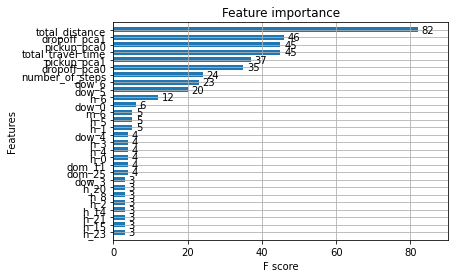

In [43]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

### Exercise: Design a Better Model

Use XGBoost GridScan or manually change some of the hyper-parameters
in order to obtain better RMSE.

In [0]:
# train another model here

## References

The [top Kaggle Kernels](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels) (executable environments to similar to Google Collab but aimed for competitions) of the New York City Taxi Trip Duration Playground competition are really good. In particular,
this notebook is heavily based on:
- [1] [Strength of visualization-python visuals tutorial](https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial) by BuryBuryZymon
- [2] [From EDA to the Top (LB 0.367)](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367) by beluga
- [3] [NYCT - from A to Z with XGBoost (Tutorial)](https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial) by KarelVerhoeven
